In [2]:
import neal
import matplotlib.pyplot as plt
from sympy import Matrix, zeros, ones, eye
from scipy import optimize 
from random import randint
from math import log2

In [68]:
class SympyMatrixFactory(object):
    
    def getMatrix(self, data):
        return Matrix(data)
    
    def getOnes(self, n, k):
        return ones(n, k)
    
    def getZeros(self, n, k):
        return zeros(n, k)
    
    def getEye(self, n):
        return eye(n)

class VariableChanger(object):
    
    def __init__(self, B, t, gamma=1, matrixFactory=SympyMatrixFactory()):
        self.B = B
        self.t = t
        self.matrixFactory = matrixFactory
        self.n = B.shape[0]
        self.k = int(log2(2 * gamma * self.n**(1/2) * abs(B.det())**(1/self.n) + sum(abs(t[i]) for i in range(self.n))))
        self.T = self.__create_transition_matrix(self.n, self.k)
        self.d = 2**self.k * self.matrixFactory.getOnes(self.n, 1)
        
    def __create_transition_matrix(self, n, k):
        data = [[0 for i in range((self.k + 1)*self.n)] for j in range(self.n)]
        T = self.matrixFactory.getMatrix(data)
        for i in range(self.n):
            T[i, i*(self.k+1):i*(self.k+1)+self.k+1] = self.matrixFactory.getMatrix([[2**j for j in range(self.k+1)]])
        
        return T
    
    """Computing quadratic form's coefficients in QUBO variables"""
    def change_quadratic_form(self):
        quadratic_part = self.T.T @ self.B.T @ self.B @ self.T
        linear_part = -2 * self.d.T @ self.B.T @ self.B @ self.T - 2 * self.t.T @ self.B @ self.T
        const = self.d.T @ self.B.T @ self.B @ self.d + 2 * self.d.T @ self.B.T @ self.t + self.t.T @ self.t
        
        return quadratic_part, linear_part, const[0]
    
    """Going from integer variables to QUBO ones"""
    def straight_change_variables(self, x):
        res = self.matrixFactory.getZeros(self.n*(self.k + 1), 1)
        
        for i in range(len(x)):
            bin_repr = list(bin(x[i] + 2**self.k)[2:].zfill(self.k+1)[::-1])
            bin_repr = list(map(lambda el: [int(el)], bin_repr))
            res[(self.k+1)*i:(self.k+1)*(i+1), 0] = bin_repr
        
        return res
    
    """Going from QUBO variables to integer ones"""
    def backward_change_variables(self, x):
        return self.T@x - self.d
    
def compute_form(Q, L, C, x):
    return (x.T@Q@x)[0] + (L@x)[0] + C

In [4]:
"""Tests for VariableChanger class"""
n = 5
N = 16
B = Matrix([[randint(-2**(N-1), 2**(N-1)-1) for _ in range(n)] for _ in range(n)], dtype=object)
t = Matrix([[randint(-2**(N-1), 2**(N-1)-1)] for _ in range(n)])
var_changer = VariableChanger(B, t)

"""Test for variable changing methods"""
x = Matrix([[randint(-2**(N-1), 2**(N-1)-1)] for _ in range(n)])
x1 = var_changer.straight_change_variables(x)
print(x == var_changer.backward_change_variables(x1))

"""Test for quadratic form's coefficients computing method"""
q, l, c = var_changer.change_quadratic_form()
norm1 = compute_form(B.T@B, -2*t.T@B, (t.T@t)[0], x)
norm2 = compute_form(q, l, c, x1)
norm3 = (B@x - t).dot(B@x - t)
print(norm1 == norm2)
print(norm2 == norm3)

True
True
True


In [29]:
class VectorSet(object):
    
    def __init__(self, norm, vectors, prob):
        self.norm = norm
        self.vectors = vectors
        self.prob = prob
        
class Solver(object):
    
    def __init__(self, B, t, gamma=1, matrix_factory=SympyMatrixFactory(), sampler=neal.SimulatedAnnealingSampler()):
        self.B, self.t = B, t
        self.matrix_factory = matrix_factory
        self.var_changer = VariableChanger(B, t, gamma, matrix_factory)
        self.sampler = sampler
        
    def __norm(self, x):
        return ((self.B@x - self.t).T @ (self.B@x - self.t))[0]
        
    def __generate_qubo_input(self, quadratic, linear):
        Q = {}
    
        for i in range(quadratic.shape[0]):
            for j in range(i, quadratic.shape[1]):
                tmp = (f"x_{i}", f"x_{j}")
                Q[tmp] = int(quadratic[i, j] + linear[i]) if i == j else int(2*quadratic[i, j])
            
        return Q

    def __dict_to_vector(self, vec_repr):
        vec = self.matrix_factory.getZeros(len(vec_repr), 1)
        
        for record in list(vec_repr.items()):
            vec[int(record[0][2:])] = record[1]
            
        return vec
    
    def __interpret_qubo_output(self, sampleset, const, num_reads):
        res = {}
    
        for sample in sampleset.data():
            x = self.var_changer.backward_change_variables(self.__dict_to_vector(sample.sample))
            val = self.__norm(x)
        
            if val in res:
                res[val][0].append(x)
                res[val][1] += 1/num_reads
            else:
                res[val] = [[x], 1/num_reads]
        
        return list(map(lambda x: VectorSet(x[0], x[1][0], x[1][1]), res.items()))
    
    def solve(self, annealing_time, num_reads):
        q, l, c = self.var_changer.change_quadratic_form()
        Q = self.__generate_qubo_input(q, l)

        self.sampler.annealing_time=annealing_time
        sampleset = self.sampler.sample_qubo(Q, num_reads=num_reads)
        
        return self.__interpret_qubo_output(sampleset, c, num_reads)

In [125]:
class LatticeFactory(object):
    
    def __init__(self, matrix_factory=SympyMatrixFactory()):
        self.matrix_factory = matrix_factory
        
    def get_lattice(self, dim, bit_length):
        B = self.matrix_factory.getEye(dim)
        k = dim - 1
        bound = 2**bit_length
        
        while k >= 0:
            B[k, dim - 1] = randint(2**(bit_length-1), bound)
            bound = B[k, dim - 1]
            k -= 1
            
        return B.T
    
    def get_vector(self, dim, bit_length):
        return self.matrix_factory.getMatrix([[randint(-2**bit_length, 2**bit_length - 1)] for _ in range(dim)])
    
    def get_zero_vector(self, dim):
        return self.matrix_factory.getMatrix([[0] for _ in range(dim)])

In [105]:
"""Class computes probabilities of ground and first two energy states"""
class TestInteractor(object):
    
    def __init__(self, B, t, sampler):
        self.B = B
        self.t = t
        self.sampler = sampler
        self.first_min = []
        self.second_min = []
        self.third_min = []
        self.T = []
        
    def compute_probabilities(self, time_bounds, num_reads):
        self.first_min.clear()
        self.second_min.clear()
        self.third_min.clear()
        self.T.clear()

        for i in range(time_bounds[0], time_bounds[1]+1):
            solver = Solver(B, t, 1)
            res = solver.solve(2**i, num_reads)
            res.sort(key=lambda x: x.norm)
            self.T.append(2**i)
            self.first_min.append(res[0].prob)
            self.second_min.append(res[1].prob)
            self.third_min.append(res[2].prob)
            print(f"annealing time = {2**i} is done")
            
        return self.T, self.first_min, self.second_min, self.third_min
    
    def show_plot(self, show=True, image_name=None, legend_loc="best", xlim=None, ylim=None):
        plt.clf()
        plt.xscale("log", base=2)
        
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)
            
        plt.plot(T, first_min, ".r-", label=r"ground state")
        plt.plot(T, second_min, ".b-", label=r"first energy level")
        plt.plot(T, third_min, ".g-", label=r"second energy level")
        plt.legend(loc=legend_loc)
        
        if image_name is not None:
            plt.savefig(image_name, dpi=300, bbox_inches='tight')
        if show:
            plt.show()

In [138]:
lattice_factory = LatticeFactory()
B = lattice_factory.get_lattice(3, 4)
t = lattice_factory.get_zero_vector(3)
print(B)
print(t)

Matrix([[1, 0, 0], [0, 1, 0], [9, 13, 14]])
Matrix([[0], [0], [0]])


In [141]:
simulated_test_interactor = TestInteractor(B, t, neal.SimulatedAnnealingSampler())
T, first_min, second_min, third_min = simulated_test_interactor.compute_probabilities((2, 12), 10000)

annealing time = 4 is done
annealing time = 8 is done
annealing time = 16 is done
annealing time = 32 is done
annealing time = 64 is done
annealing time = 128 is done
annealing time = 256 is done
annealing time = 512 is done
annealing time = 1024 is done
annealing time = 2048 is done
annealing time = 4096 is done


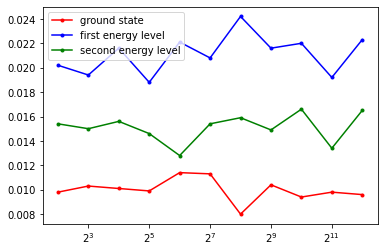

In [142]:
simulated_test_interactor.show_plot(image_name="energy_levels_simulated.png")